# Import and functions

In [145]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import ndimage
import pandas as pd

%matplotlib inline

In [146]:
import import_ipynb
try:
    os.chdir('Modules')
except:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\retina_python\\Modules')
from time_shifted_PID import MIfunc
from time_shifted_PID import EqualState
# from StimulusnResponse import SSG
from Spike_Generation import SG
from Spike_Generation import Spike_Time_Generater
from Spike_Generation import NL

In [147]:
def NGD_TK(T, m, n, alpha, beta, g, tau_y):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    y = np.zeros_like(x)
    z = np.zeros_like(x)
    
    for i in range(len(T)):
        y[i] = y[i-1] + dt*(-alpha*y[i-1]+m*x[i-1]-n*z[i-1])
        z[i] = z[i-1] + dt*( -beta*z[i-1]+g*y[i-1])
    return y[:len(T):50], z[:len(T):50]

# Set Parameter

In [148]:
m = 16.416565
n =	500
alpha = 41.464099
beta = 2.088120
g =  1729.111153/n
tau_y = 0.051583

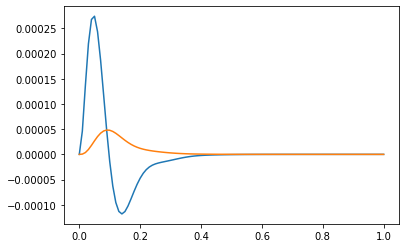

In [149]:
dt = 0.01
TKaxis = np.arange(101)*dt

k_E, k_S = NGD_TK(TKaxis, m, n, alpha, beta, g, tau_y)
# y_TK, w_TK = NGD_TK(TKaxis, *[2.67758918, 1.00000000, 1.17089092e+01, 4.69398540, 4.73653606e+02, 2.45547756e-02])
plt.plot(TKaxis, k_E)
plt.plot(TKaxis, k_S)

In [150]:
tot = 300
tAxis = np.arange(0,tot,dt)
# OU ; input
tau = 1
D = 1
OU=np.zeros(len(tAxis))
mu, sigma = 0, 1
for i in range(len(tAxis)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+np.sqrt(D*dt)*np.random.normal(mu,sigma)
# filtering for OUSmoothed
Fc = 1
b, a = signal.butter(2, 2*Fc*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)
x = (LPOU-np.mean(LPOU))/np.std(LPOU)

In [151]:
amp = 2
mean = 10
baseOutput = np.convolve(np.hstack((np.zeros(len(k_E)), x))*amp+mean, -k_E, 'full')[len(k_E):len(k_E)+len(x)]

In [152]:
window = [-1,1] # second
timeaxis = np.arange(-100,101)*dt

x = np.array(LPOU)
x = (x-np.mean(x))/np.std(x)

theta_star = 0

r = baseOutput
r = NL(r, np.mean(r) + theta_star*np.std(r))
Xcorr = np.correlate(x, r, 'same') / np.correlate(np.ones_like(x), r, 'same')
baseXcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]

In [153]:
tv = ndimage.gaussian_filter1d(LPOU, order=1, sigma=1)/dt
#assign states
state_num = 6
xstate = EqualState(LPOU, state_num)[0]
tvstate = EqualState(tv, state_num)[0]

baserstate = SG(baseOutput, dt, theta_star, 10, 2)
timeshift, baseMI = MIfunc(baserstate, xstate, dt, window, perSpike = True)

# +SFB

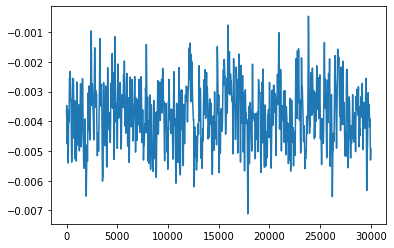

In [154]:
plt.plot(baseOutput)

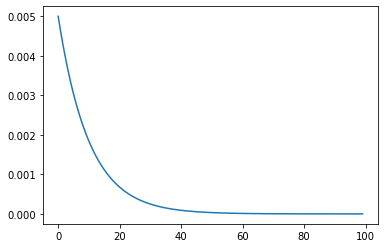

In [155]:
tau_P = 0.1 #s
sigma_b = 0.005
expDecay = np.exp(-np.arange(0,1,dt)/tau_P)*sigma_b
plt.plot(expDecay)

In [156]:
def SFB(input, expDecay, theta):
    test = 0
    h = input.copy()
    rstate = np.zeros_like(baseOutput)
    for i in range(len(h)):
        if h[i] > theta:
            rstate[i] = 1
            h[i+1:min(i+len(expDecay),len(h))] -= expDecay[1:min(len(expDecay),len(h)-i)]
    return rstate, h

# DCCM

In [157]:
contrast_list = np.array([0.05,0.1,0.15,0.2,0.3])
DCCM_rstate = [0]*len(contrast_list)
for i in range(len(contrast_list)):
    output = np.convolve(np.hstack((np.zeros(len(k_E)), x))*contrast_list[i]*mean+mean, -k_E, 'full')[len(k_E):len(k_E)+len(x)]
    theta = np.mean(output)+theta_star*np.std(output)
    DCCM_rstate[i], _ = SFB(output, expDecay, theta) # GC after rectifier

(5000.0, 6000.0)

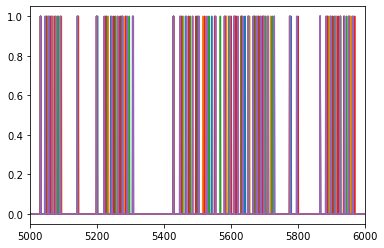

In [158]:
for i in range(len(contrast_list)):
    plt.plot(DCCM_rstate[i])
plt.xlim(5000,6000)

### STA

In [159]:
x = np.array(LPOU)
x = (x-np.mean(x))/np.std(x)

DCCM_Xcorr = [0]*len(contrast_list)
for i in range(len(contrast_list)):
    Xcorr = np.correlate(x, DCCM_rstate[i], 'same') / np.correlate(np.ones_like(x), DCCM_rstate[i], 'same')
    Xcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]
    DCCM_Xcorr[i] = Xcorr.copy()

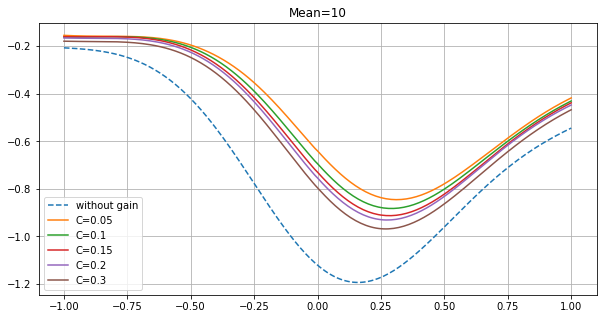

In [160]:
plt.plot(timeaxis,baseXcorr, label= 'without gain', linestyle= 'dashed' )
for i in range(len(contrast_list)): 
    plt.plot(timeaxis,DCCM_Xcorr[i], label = 'C='+str(round(contrast_list[i],3)))
plt.legend()
plt.title('Mean='+str(mean))
plt.grid('on')
plt.gcf().set_size_inches(10,5)

### MI

In [161]:
DCCM_MI = [0]*len(contrast_list)
for i in range(len(contrast_list)):
    timeshift, DCCM_MI[i] = MIfunc(DCCM_rstate[i], xstate, dt, window, perSpike = True)

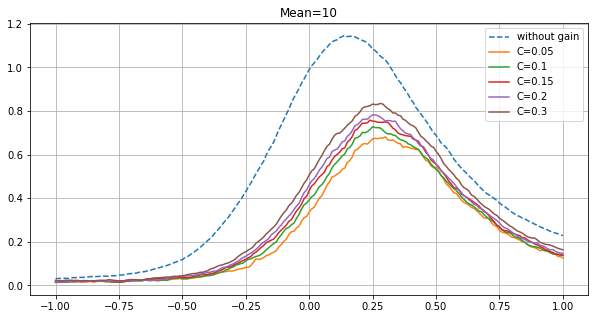

In [162]:
plt.plot(timeaxis,baseMI, label= 'without gain', linestyle= 'dashed' )
for i in range(len(contrast_list)): 
    plt.plot(timeaxis,DCCM_MI[i], label = 'C='+str(round(contrast_list[i],3)))
plt.legend()
plt.title('Mean='+str(mean))
plt.grid('on')
plt.gcf().set_size_inches(10,5)

# CCDM

In [163]:

mag_list = np.arange(0.2,2.,0.2)
mag_list = [0.2,0.4,0.7,1,1.3]
CCDM_rstate = [0]*len(mag_list)
for i in range(len(mag_list)):
    output = np.convolve( (np.hstack((np.zeros(len(k_E)), x))*amp+mean)*mag_list[i], -k_E, 'full')[len(k_E):len(k_E)+len(x)]
    theta = np.mean(output)+theta_star*np.std(output)
    CCDM_rstate[i], _ = SFB(output, expDecay, theta) # GC after rectifier

(5000.0, 6000.0)

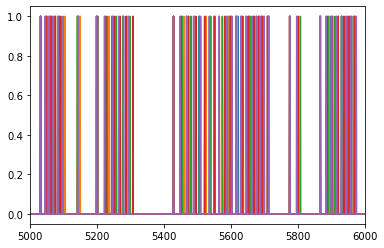

In [164]:
for i in range(len(mag_list)):
    plt.plot(CCDM_rstate[i])
plt.xlim(5000,6000)

### STA

In [165]:
CCDM_Xcorr = [0]*len(mag_list)
for i in range(len(mag_list)):
    Xcorr = np.correlate(x, CCDM_rstate[i], 'same') / np.correlate(np.ones_like(x), CCDM_rstate[i], 'same')
    Xcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]
    CCDM_Xcorr[i] = Xcorr.copy()

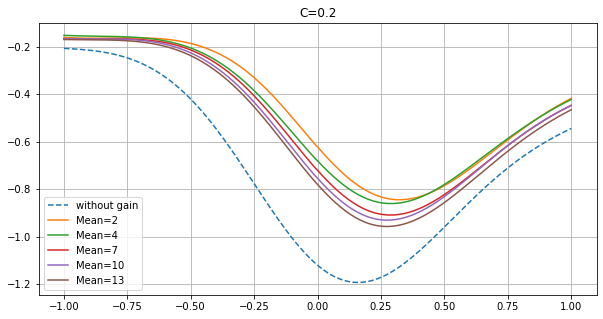

In [166]:
plt.plot(timeaxis,baseXcorr, label= 'without gain', linestyle= 'dashed' )
for i in range(len(mag_list)): 
    plt.plot(timeaxis,CCDM_Xcorr[i], label = 'Mean='+str(round(mag_list[i]*mean)))
plt.legend()
plt.title('C='+str(amp/mean))
plt.grid('on')
plt.gcf().set_size_inches(10,5)

### MI

In [167]:
CCDM_MI = [0]*len(mag_list)
for i in range(len(mag_list)):
    timeshift, CCDM_MI[i] = MIfunc(CCDM_rstate[i], xstate, dt, window, perSpike = True)

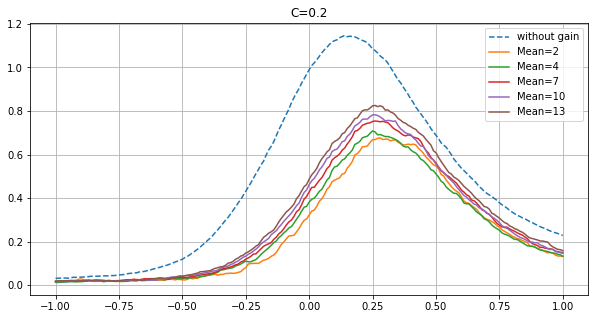

In [168]:
plt.plot(timeaxis,baseMI, label= 'without gain', linestyle= 'dashed' )
for i in range(len(mag_list)): 
    plt.plot(timeaxis,CCDM_MI[i], label = 'Mean='+str(round(mag_list[i]*mean)))
plt.legend()
plt.title('C='+str(amp/mean))
plt.grid('on')
plt.gcf().set_size_inches(10,5)